## BloomTech Data Science

---

# Classification Metrics

- get and interpret the **confusion matrix** for classification models
- use classification metrics: **precision, recall**
- understand the relationships between precision, recall, **thresholds, and predicted probabilities**, to help **make decisions and allocate budgets**

In [1]:
%%capture
!pip install category_encoders==2.*

In [2]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Downloading the Tanzania Waterpump Dataset

Make sure  you only use the dataset that is available through the **DS** **Kaggle Competition**. DO NOT USE any other Tanzania waterpump datasets that you might find online.

There are two ways you can get the dataset. Make sure you have joined the competition first!:

1. You can download the dataset directly by accessing the challenge and the files through the Kaggle Competition URL on Canvas (make sure you have joined the competition!)

2. Use the Kaggle API using the code in the following cells. This article provides helpful information on how to fetch your Kaggle Dataset into Google Colab using the Kaggle API.

> https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a

# Using Kaggle API to download datset

In [3]:
# # mounting your google drive on colab
# from google.colab import drive
# drive.mount('/content/gdrive')

In [4]:
#change your working directory, if you want to or have already saved your kaggle dataset on google drive.
# %cd /content/gdrive/My Drive/Kaggle
# update it to your folder location on drive that contains the dataset and/or kaggle API token json file.

In [5]:
# Download your Kaggle Dataset, if you haven't already done so.
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# !kaggle competitions download -c bloomtech-water-pump-challenge

In [6]:
# Unzip your Kaggle dataset, if you haven't already done so.
# !unzip \*.zip  && rm *.zip

In [7]:
# List all files in your Kaggle folder on your google drive.
!ls

sample_data  test_features.csv	train_features.csv  train_labels.csv


# I. Wrangle Data

In [21]:
def wrangle(fm_path, tv_path=None):
  if tv_path:
    df = pd.merge(pd.read_csv(fm_path,
                              na_values=[0, -2.000000e-08],
                              parse_dates=['date_recorded']),
                  pd.read_csv(tv_path)).set_index('id')



  else:

    df = pd.read_csv(fm_path,
                     na_values=[0, -2.000000e-08],
                     parse_dates=['date_recorded'],
                     index_col='id')


  # Drop constant columns
  df.drop(columns=['recorded_by'], inplace=True)

  # Create age feature
  df['pump_age'] = df['date_recorded'].dt.year - df['construction_year']
  df.drop(columns='date_recorded', inplace=True)

  # Drop HCCCs
  cutoff = 100
  drop_cols = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > cutoff]
  df.drop(columns=drop_cols, inplace=True)

  # Drop duplicate columns # check for atleast a 100 values
  dupe_cols = [col for col in df.head(100).T.duplicated().index
               if df.head(100).T.duplicated()[col]]
  df.drop(columns=dupe_cols, inplace=True)

  if 'status_group' in df:

    df['needs_repair'] = np.where(df['status_group']=='functional',0,1)
    df.drop(columns='status_group', inplace=True)
  # delete status group column


  return df

df = wrangle(fm_path='train_features.csv',
             tv_path='train_labels.csv')

X_test = wrangle(fm_path='test_features.csv')

In [22]:
df.head()

,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,...,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,pump_age,needs_repair
id,,,,,,,,,,,,,,,,,,,,,
454.0,50.0,2092.0,35.426020,-4.227446,NaN,Internal,Manyara,21,1.0,160.0,...,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,15.0,0
510.0,NaN,NaN,35.510074,-5.724555,NaN,Internal,Dodoma,1,6.0,NaN,...,soft,good,enough,shallow well,shallow well,groundwater,hand pump,hand pump,NaN,0
14146.0,NaN,NaN,32.499866,-9.081222,NaN,Lake Rukwa,Mbeya,12,6.0,NaN,...,soft,good,enough,shallow well,shallow well,groundwater,other,other,NaN,1
47410.0,NaN,NaN,34.060484,-8.830208,NaN,Rufiji,Mbeya,12,7.0,NaN,...,soft,good,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,NaN,1
1288.0,300.0,1023.0,37.032690,-6.040787,NaN,Wami / Ruvu,Morogoro,5,1.0,120.0,...,salty,salty,enough,shallow well,shallow well,groundwater,other,other,14.0,1


## EDA


In [9]:
# Classify into pumps that need repair and pumps that do not need repairs.
# functional - class 0
# non functional, functional needs repair - class 1

In [10]:
# OPTION 1
#df['needs_repair'] = np.where(df['status_group']=='functional',0,1)

In [25]:
# OPTION 3
df['status_group'].apply(lambda x: 0 if x=='functional' else 1)

KeyError: 'status_group'

In [ ]:
df['needs_repair'].value_counts()

# II. Split Data

In [12]:
# Split TV / FM
target = 'needs_repair'
X = df.drop(columns=target)
y = df[target]

# Train-val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Sanity check
assert len(X_train) + len(X_val) == len(X)

# Baseline

In [13]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5425489938182296


# Build Model


In [14]:
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=25, n_jobs=-1, random_state=42),
)

model.fit(X,y)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoin...
communal standpipe multiple    4
improved spring                5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                                         {'col': 'waterpoint_type_group',
                                          'data_type': dtype('O'),
                                          'mapping': communal standpipe    1
hand pump             2
other                 3
improved spring       4
cattle trough         5
dam                   6
NaN                  -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=25, n_jobs=-1,
                                        random_state=42))])

# Interlude: Beware or Leakage

If you leave `'status_group'` in your feature matrix, you'll have **leakage**.

<Axes: >

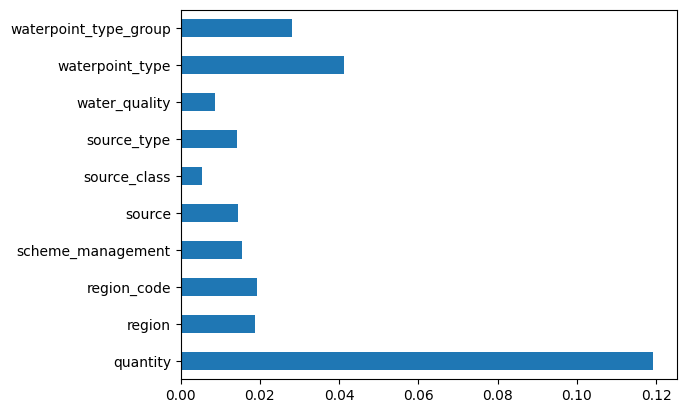

In [15]:
importances = model.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns
pd.Series(importances, index=features).sort_index().tail(10).plot(kind='barh')

# Check Metrics

**Accuracy Score**

In [23]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))

Training Accuracy: 0.993423648559779
Validation Accuracy: 0.9937920875420876


In [24]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))

Training Accuracy: 0.993423648559779
Validation Accuracy: 0.9937920875420876


**Confusion Matrix**

In [16]:
plot_confusion_matrix = ConfusionMatrixDisplay.from_estimator

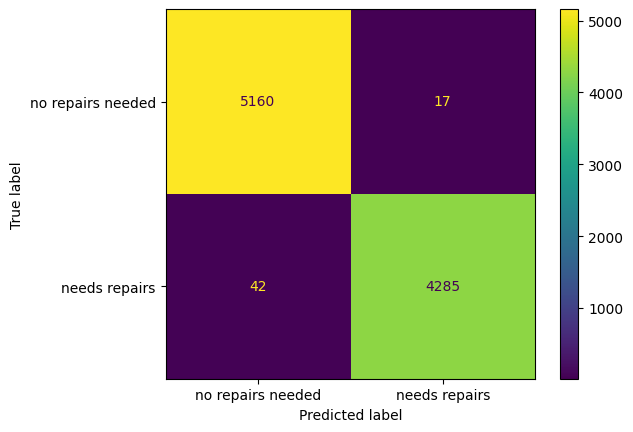

In [17]:
plot_confusion_matrix(
    model,
    X_val,
    y_val,
    values_format='.0f',
    display_labels = ['no repairs needed', 'needs repairs']
);

**Precision Score**

Of all the pumps that you predicted as needing repair, what proportion actually needed repair?

In [18]:
precision = tp / (tp + fp)

NameError: name 'tp' is not defined

In [20]:
precision = 4285 / (4285 + 17)

print(precision)

0.996048349604835


**Recall Score**

Of those pumps that actually needed repair, what proportion did you correctly predict as needing repair?

In [ ]:
# recall tp/(tp+fn)

**Classification Report**

In [30]:
print(classification_report(y_val,
                      model.predict(X_val),
                      target_names = ['no_repairs_needed','repair_needed']))




                   precision    recall  f1-score   support

no_repairs_needed       0.99      1.00      0.99      5177
    repair_needed       1.00      0.99      0.99      4327

         accuracy                           0.99      9504
        macro avg       0.99      0.99      0.99      9504
     weighted avg       0.99      0.99      0.99      9504



# Case Study

Let's say that is costs the Tanzanian government $100 to inspect a water pump, and there is only funding for 2000 pump inspections.

In [31]:
n_inspections = 2000

In [32]:
y_val.value_counts(normalize=True)

0    0.544718
1    0.455282
Name: needs_repair, dtype: float64

In [34]:
repair_prob = 0.455282

Scenario 1: Choose pumps randomly

In [35]:

print('Inspections conducted:',n_inspections)
print('Pumps repaired:',n_inspections * repair_prob )
print('Funds wasted:', int(n_inspections - n_inspections * repair_prob ) * 100)

Inspections conducted: 2000
Pumps repaired: 910.5640000000001
Funds wasted: 108900


Scenario 2: Using our model "out of the box"

In [36]:
data = {
    'y_val':y_val,
    'y_pred': model.predict(X_val)
}

results =pd.DataFrame(data)

In [37]:
mask = (results['y_val'] == 1)

sample = results[mask].sample(n_inspections)

In [38]:
print('Inspections conducted:',n_inspections)
print('Pumps repaired:', sample['y_val'].sum() )
print('Funds wasted:',int(n_inspections-sample['y_val'].sum()) * 100)

Inspections conducted: 2000
Pumps repaired: 2000
Funds wasted: 0


Scenario 3: We empasize **precision** in our model, and only select pumps that our model is very certain (`>0.85`) need repair.

In [40]:
data = {
    'y_val':y_val,
    'y_pred_proba': model.predict_proba(X_val)[:-1]
}

results =pd.DataFrame(data)

ValueError: Per-column arrays must each be 1-dimensional

In [ ]:
threshold = 0.85

In [ ]:
print('Inspections conducted:', )
print('Pumps repaired:', )
print('Funds wasted:', )
